### CCTS 40500: FINAL
#### Abdallah Aboelela

In [163]:
# General
import numpy as np
import pandas as pd

# For plotting
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

# Keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

# Sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

# For fun
from sklearn.ensemble import RandomForestClassifier

In [164]:
# setup
seed = 7
np.random.seed(seed)
files = ['hiv-db-LTNP.seq', 'hiv-db-SP.seq', 'hiv-db-zRP.seq']

In [165]:
# load dataset
combined = pd.DataFrame()
for fname in files:
    df = pd.read_csv('data/' + fname, header = None)
    df['type'] = fname
    combined = pd.concat([combined, df])
    
combined = combined.replace('hiv-db-LTNP.seq', 'LTNP')
combined = combined.replace('hiv-db-zRP.seq', 'RP')
combined = combined.replace('hiv-db-SP.seq', 'SP')

combined.columns = ['seq', 'type']
combined['len'] = combined.seq.apply(len)

In [166]:
for i in range(max(combined.len)):
    combined[i] = combined.seq.apply(lambda x: get_position(x, i))
    
combined = combined.drop(['seq', 'len'], axis = 1)

In [167]:
combined.head()

type  0  1  2  3  4  5  6  7  8 ...  9830 9831 9832 9833 9834 9835 9836  \
0  LTNP  A  A  G  C  G  A  A  A  G ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  LTNP  C  C  C  G  A  A  C  A  G ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2  LTNP  A  A  A  C  C  A  G  A  G ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3  LTNP  A  C  A  G  G  G  A  C  T ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4  LTNP  T  G  A  A  A  A  C  A  A ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN   

  9837 9838 9839  
0  NaN  NaN  NaN  
1  NaN  NaN  NaN  
2  NaN  NaN  NaN  
3  NaN  NaN  NaN  
4  NaN  NaN  NaN  

[5 rows x 9841 columns]

In [168]:
combined = combined.replace(['A', 'T', 'G', 'C'], list(range(4)))
combined = combined.replace(np.nan, int(4))

#### Attempt using random forest

In [169]:
rf_clf = RandomForestClassifier(n_estimators = 100)
kfold = KFold(n_splits=10, shuffle=True, random_state = seed)
results = cross_val_score(rf_clf, combined.drop('type', axis = 1), combined.type, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 74.89% (10.96%)


#### Attempt at Neural Net

In [170]:
k_clf = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(k_clf, combined.drop('type', axis = 1), combined.type, cv=kfold, error_score = 'raise')
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 45.11% (14.81%)


#### Attempt at creating a single layer auto-encoder/decoder

In [208]:
X_train, X_test, y_train, y_test = train_test_split(combined.drop('type', axis = 1), 
                                                    combined.type, random_state=seed)

In [209]:
input_img = Input(shape=(9840,))
encoded = Dense(4920, activation='relu')(input_img)
decoded = Dense(9840, activation='sigmoid')(encoded)
single_autoencoder = Model(input_img, decoded)

In [210]:
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(4920,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

single_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [211]:
single_autoencoder.fit(X_train, X_train,
                       epochs=25,
                       batch_size=256,
                       shuffle=True,
                       validation_data=(X_test, X_test))

Train on 101 samples, validate on 34 samples
Epoch 1/25
101/101 [==============================] - 10s 98ms/step - loss: 0.8881 - val_loss: -0.4273
Epoch 2/25
101/101 [==============================] - 5s 54ms/step - loss: -0.3449 - val_loss: -4.1378
Epoch 3/25
101/101 [==============================] - 2s 21ms/step - loss: -3.7432 - val_loss: -6.6264
Epoch 4/25
101/101 [==============================] - 2s 19ms/step - loss: -6.2393 - val_loss: -7.1081
Epoch 5/25
101/101 [==============================] - 2s 19ms/step - loss: -6.7822 - val_loss: -7.1199
Epoch 6/25
101/101 [==============================] - 2s 19ms/step - loss: -6.8069 - val_loss: -7.1430
Epoch 7/25
101/101 [==============================] - 2s 21ms/step - loss: -6.8384 - val_loss: -7.1452
Epoch 8/25
101/101 [==============================] - 3s 32ms/step - loss: -6.8430 - val_loss: -7.1316
Epoch 9/25
101/101 [==============================] - 2s 22ms/step - loss: -6.8296 - val_loss: -7.1413
Epoch 10/25
101/101 [=======

In [225]:
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs) * 5 // 1

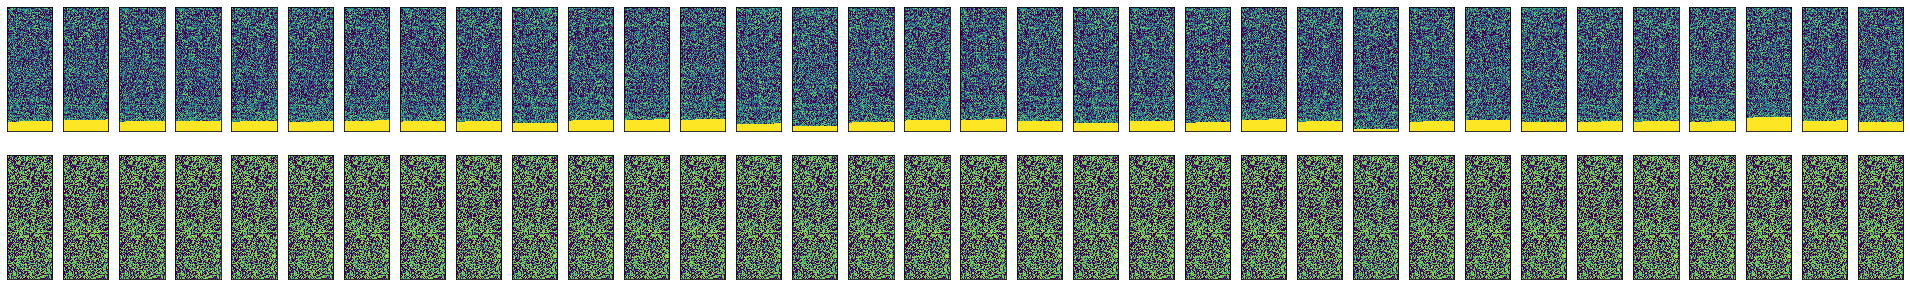

In [226]:
n = 34  # how many sequences we will display
plt.figure(figsize=(34, 5))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(np.array(X_test.iloc[i, :]).reshape(164, 60))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(164, 60))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Appendix

In [25]:
def get_position(x, i):
    try:
        return x[i]
        
    except Exception as e:
        return np.nan

In [26]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=9840, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model